In [1]:
 from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/ADM_Final_Project

/content/gdrive/My Drive/ADM_Final_Project


In [3]:
! git clone https://github.com/Microsoft/Recommenders

fatal: destination path 'Recommenders' already exists and is not an empty directory.


In [4]:
!pip install papermill

     |████████████████████████████████| 1.1MB 12.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 727kB 13.9MB/s 
     |████████████████████████████████| 747kB 17.8MB/s 
     |████████████████████████████████| 112kB 41.3MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124185 sha256=d863cf928b217c86ddc2d04e0622d70f2b1e98e686b006637d0dd3e9e63cdee1
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


In [5]:
!pip install surprise

     |████████████████████████████████| 11.8MB 7.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670915 sha256=52fd5eaae366f5e27824891aa2016c8d72c88919762e7c4a4c02101e289f66b6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [6]:
import os
os.chdir('/content/gdrive/My Drive/ADM_Final_Project/Recommenders')

In [7]:
import sys
sys.path.append("../../")
import os
import surprise
import papermill as pm
import pandas as pd
import numpy as np
import datetime as dt
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_random_split
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from reco_utils.recommender.surprise.surprise_utils import predict, compute_ranking_predictions

print("System version: {}".format(sys.version))
print("Surprise version: {}".format(surprise.__version__))

System version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Surprise version: 1.1.1


## 1. Load Data

In [8]:
 data = pd.read_csv('/content/gdrive/My Drive/ADM_Final_Project/reg_lost.csv',sep=',')


# Convert the float precision to 32-bit in order to reduce memory consumption 
#data['Review'] = data['Review'].astype(np.float32)
#data['Customer_ID'] = data['Review'].astype(int)
data['Order_Date'] = pd.to_datetime(data['Order_Date'])
data['Timestamp'] =(data['Order_Date'] - dt.datetime(1970,1,1)).dt.total_seconds()

data.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,City,State,Country,Postal_Code,Market,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Rating,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore,Type,Timestamp
0,42433,AG-2011-2040,2014-01-01,6/1/2014,Standard Class,8,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,1,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium,4.0,109,8,935.77550,2032.0,1,3,2,132,Regular,1.388534e+09
1,22253,IN-2011-47883,2014-01-01,8/1/2014,Standard Class,9,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,1,Office Supplies,Storage,"Tenex Lockers, Blue",120.366,3,0.1,36.036,9.72,Medium,4.5,98,3,674.94600,2254.0,1,2,2,122,Regular,1.388534e+09
2,48883,HU-2011-1220,2014-01-01,5/1/2014,Second Class,12,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,1,Office Supplies,Storage,"Tenex Lockers, Blue",66.120,4,0.0,29.640,8.17,High,4.0,15,44,9386.25960,383.0,3,4,4,344,Regular,1.388534e+09
3,11731,IT-2011-3647632,2014-01-01,5/1/2014,Second Class,20,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,1,Office Supplies,Storage,"Tenex Lockers, Blue",44.865,3,0.5,-26.055,4.82,High,4.0,2,13,1783.23420,1553.0,4,3,3,433,Regular,1.388534e+09
4,22255,IN-2011-47883,2014-01-01,8/1/2014,Standard Class,24,Patrick O'Donnell,Consumer,Dhaka,Dhaka,Bangladesh,NaN,APAC,Central Asia,1,Office Supplies,Storage,"Tenex Lockers, Blue",113.670,5,0.1,37.770,4.70,Medium,4.0,13,65,12592.59918,234.0,3,4,4,344,Regular,1.388534e+09


In [9]:
data_reg=data[['Customer_ID','ProductID','Rating']]
data_reg.columns = ['userID', 'itemID','rating']
data_reg.dtypes

userID      int64
itemID      int64
rating    float64
dtype: object

# 1.2 Train the SVD Model

In [10]:
train, test = python_random_split(data_reg, 0.75)

In [11]:
# 'reader' is being used to get rating scale (for MovieLens, the scale is [1, 5]).
# 'rating_scale' parameter can be used instead for the later version of surprise lib:
# https://github.com/NicolasHug/Surprise/blob/master/surprise/dataset.py
train_set = surprise.Dataset.load_from_df(train, reader=surprise.Reader('ml-100k')).build_full_trainset()
train_set

In [12]:
svd = surprise.SVD(random_state=0, n_factors=200, n_epochs=30, verbose=True)

with Timer() as train_time:
    svd.fit(train_set)

print("Took {} seconds for training.".format(train_time.interval))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Took 2.481410861999848 seconds for training.


# 1.3 Prediction

In [13]:
predictions = predict(svd, test, usercol='userID', itemcol='itemID')
predictions.head()

,userID,itemID,prediction
0,1876,86,3.086548
1,2333,153,3.127388
2,922,296,4.924107
3,512,7,2.106025
4,133,25,3.323310



# 1.4 Remove rated products in the top k recommendations

In [14]:
## Removing the items already bought by customers
with Timer() as test_time:
    all_predictions = compute_ranking_predictions(svd, data_reg, usercol='userID', itemcol='itemID', remove_seen=True)
    
print("Took {} seconds for prediction.".format(test_time.interval))

Took 9.732666653999786 seconds for prediction.


In [15]:
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)
eval_rsquared = rsquared(test, predictions)
eval_exp_var = exp_var(test, predictions)

k = 10
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)


print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

print('----')

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE:		0.956878
MAE:		0.740186
rsquared:	0.201384
exp var:	0.201442
----
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000


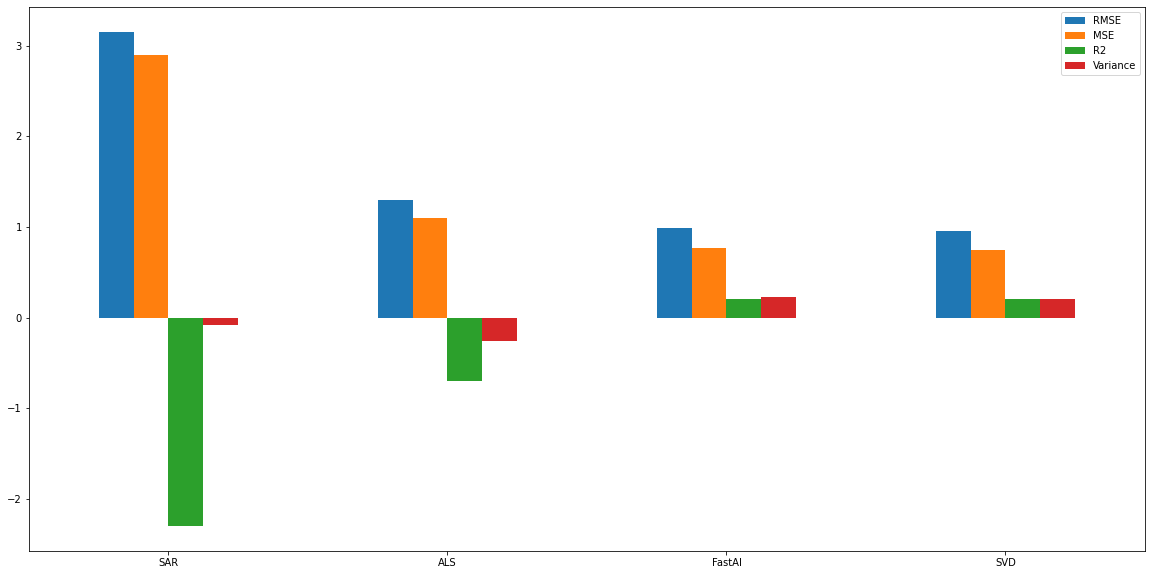

In [26]:
RMSE = [3.15,1.3,0.99,0.95]
MSE = [2.9,1.1,0.77,0.74]
R2 = [-2.3,-0.7,0.2,0.2]
Exp_Var = [-0.08,-0.26,0.23,0.2]
index=['SAR','ALS','FastAI','SVD']
df = pd.DataFrame({'RMSE':RMSE,'MSE':MSE,'R2':R2,'Variance':Exp_Var}, index = index)
ax=df.plot.bar(rot=0,figsize=(20,10))


In [27]:
all_predictions.count()

userID        1077117
itemID        1077117
prediction    1077117
dtype: int64

In [28]:
from google.colab import files
all_predictions.to_csv('all_predictions.csv')